<a href="https://colab.research.google.com/github/Jinxz117/stat-ai/blob/main/Copy_of_Performance_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualizations

In [ ]:
# Configurable parameters for dynamic use
CONFIG = {
    'file_path': '/content/drive/MyDrive/Colab Notebooks/Data Sets/dt10.csv',  # Path to your CSV
    'date_column': None,  # Optional for stats; set for consistency
    'value_column': None,  # Sales/revenue column; auto-detect
    'date_format': '%d/%m/%Y',  # Optional
    'product_keywords': ['product', 'item', 'name'],  # For auto-detecting product column
    'category_keywords': ['category', 'brand', 'sub-category'],  # For brand/category
    'quantity_keywords': ['quantity', 'qty', 'units', 'order quantity', 'shipped', 'sold', 'count'],# For Quantity
    'top_n': 10,  # Number of top items to plot
    'plot_title_prefix': 'Sales Statistics'
}

In [ ]:
def detect_column(df, keywords):
    """
    Generic auto-detection for columns based on keywords (case-insensitive).
    Prioritizes exact matches and numeric where applicable.
    """
    for col in df.columns:
        if any(keyword.lower() in col.lower() for keyword in keywords):
            # Prefer numeric for quantity/sales
            if pd.api.types.is_numeric_dtype(df[col]):
                return col
            return col  # First match otherwise
    return None

In [ ]:
def load_data(file_path, value_col=None, date_format=None):
    """
    Load CSV and auto-detect key columns for statistics.
    Returns df and detected columns.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Auto-detect sales/value column if not specified
        if value_col is None:
            value_col = detect_column(df, ['sales', 'revenue', 'amount', 'value', 'price', 'total'])
            if value_col is None:
                raise ValueError("Could not auto-detect sales/revenue column.")
            print(f"Auto-detected sales column: {value_col}")

        # Auto-detect product/item column
        product_col = detect_column(df, CONFIG['product_keywords'])

        # Auto-detect category/brand column
        category_col = detect_column(df, CONFIG['category_keywords'])

        # Auto-detect quantity column (numeric)
        quantity_col = None
        for col in df.columns:
            if any(keyword.lower() in col.lower() for keyword in CONFIG['quantity_keywords']) and pd.api.types.is_numeric_dtype(df[col]):
                quantity_col = col
                break

        # Clean sales column
        df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
        df = df.dropna(subset=[value_col])

        if quantity_col:
            df[quantity_col] = pd.to_numeric(df[quantity_col], errors='coerce')
            df = df.dropna(subset=[quantity_col])

        detected = {
            'sales_col': value_col,
            'product_col': product_col,
            'category_col': category_col,
            'quantity_col': quantity_col
        }
        print(f"Detected columns: {detected}")
        return df, detected
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

In [ ]:
def compute_statistics(df, detected):
    """
    Compute key statistics.
    """
    sales_col = detected['sales_col']
    product_col = detected['product_col']
    category_col = detected['category_col']
    quantity_col = detected['quantity_col']

    stats = {}

    # Total revenue
    stats['total_revenue'] = df[sales_col].sum()

    # Best selling item (by revenue)
    if product_col:
        item_sales = df.groupby(product_col)[sales_col].sum().nlargest(1)
        stats['best_selling_item'] = item_sales.index[0]
        stats['best_item_revenue'] = item_sales.iloc[0]
    else:
        stats['best_selling_item'] = None

    # Best selling brand/category (by revenue)
    if category_col:
        category_sales = df.groupby(category_col)[sales_col].sum().nlargest(1)
        stats['best_selling_brand'] = category_sales.index[0]
        stats['best_brand_revenue'] = category_sales.iloc[0]
    else:
        stats['best_selling_brand'] = None

    # Most stock sold (item by quantity)
    if quantity_col and product_col:
        item_qty = df.groupby(product_col)[quantity_col].sum().nlargest(1)
        stats['most_stock_item'] = item_qty.index[0]
        stats['most_stock_qty'] = item_qty.iloc[0]
    else:
        stats['most_stock_item'] = None

    # Biggest revenue from sales: top category or item (already covered)
    # Additional: top N for plots

    return stats

In [ ]:
def plot_statistics(df, detected, stats, top_n):
    """
    Plot top items by sales, quantity, etc.
    """
    sales_col = detected['sales_col']
    product_col = detected['product_col']
    category_col = detected['category_col']
    quantity_col = detected['quantity_col']

    plt.style.use('default')
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Top products by sales
    if product_col:
        top_sales = df.groupby(product_col)[sales_col].sum().nlargest(top_n)
        top_sales.plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'Top {top_n} Best Selling Items (Revenue)')
        axes[0].set_ylabel('Revenue')
        axes[0].tick_params(axis='x', rotation=45)

    # Top categories/brands by sales
    if category_col:
        top_cat = df.groupby(category_col)[sales_col].sum().nlargest(top_n)
        top_cat.plot(kind='bar', ax=axes[1])
        axes[1].set_title(f'Top {top_n} Brands/Categories (Revenue)')
        axes[1].set_ylabel('Revenue')
        axes[1].tick_params(axis='x', rotation=45)

    # Top items by quantity
    if quantity_col and product_col:
        top_qty = df.groupby(product_col)[quantity_col].sum().nlargest(top_n)
        top_qty.plot(kind='bar', ax=axes[2])
        axes[2].set_title(f'Top {top_n} Items by Stock Sold')
        axes[2].set_ylabel('Quantity')
        axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Total revenue summary plot (simple)
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.5, f'Total Revenue: ${stats["total_revenue"]:,.2f}',
             ha='center', va='center', fontsize=20, transform=plt.gca().transAxes)
    plt.title(f'{CONFIG["plot_title_prefix"]} - Overview')
    plt.axis('off')
    plt.show()

In [ ]:
def print_statistics(stats):
    """
    Nicely print the statistics.
    """
    print("\n" + "="*50)
    print("SALES STATISTICS SUMMARY")
    print("="*50)
    print(f"Total Revenue: ${stats['total_revenue']:,.2f}")

    if stats['best_selling_item']:
        print(f"Best Selling Item: {stats['best_selling_item']} (${stats['best_item_revenue']:,.2f})")

    if stats['best_selling_brand']:
        print(f"Best Selling Brand/Category: {stats['best_selling_brand']} (${stats['best_brand_revenue']:,.2f})")

    if stats['most_stock_item']:
        print(f"Most Stock Sold Item: {stats['most_stock_item']} (Qty: {stats['most_stock_qty']:.0f})")

    if not any([stats['best_selling_item'], stats['best_selling_brand'], stats['most_stock_item']]):
        print("Note: Could not detect product/brand/quantity columns. Stats limited to total revenue.")
    print("="*50)

In [ ]:
def main(config):
    """
    Main function to compute and display statistics.
    """
    # Load data
    df, detected = load_data(
        config['file_path'],
        config['value_column'],
        config['date_format']
    )
    if df is None:
        return

    # Compute stats
    stats = compute_statistics(df, detected)

    # Print stats
    print_statistics(stats)

    # Plot
    plot_statistics(df, detected, stats, config['top_n'])

Loaded data shape: (9800, 18)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']
Auto-detected sales column: Sales
Detected columns: {'sales_col': 'Sales', 'product_col': 'Customer Name', 'category_col': 'Category', 'quantity_col': None}

SALES STATISTICS SUMMARY
Total Revenue: $2,261,536.78
Best Selling Item: Sean Miller ($25,043.05)
Best Selling Brand/Category: Technology ($827,455.87)


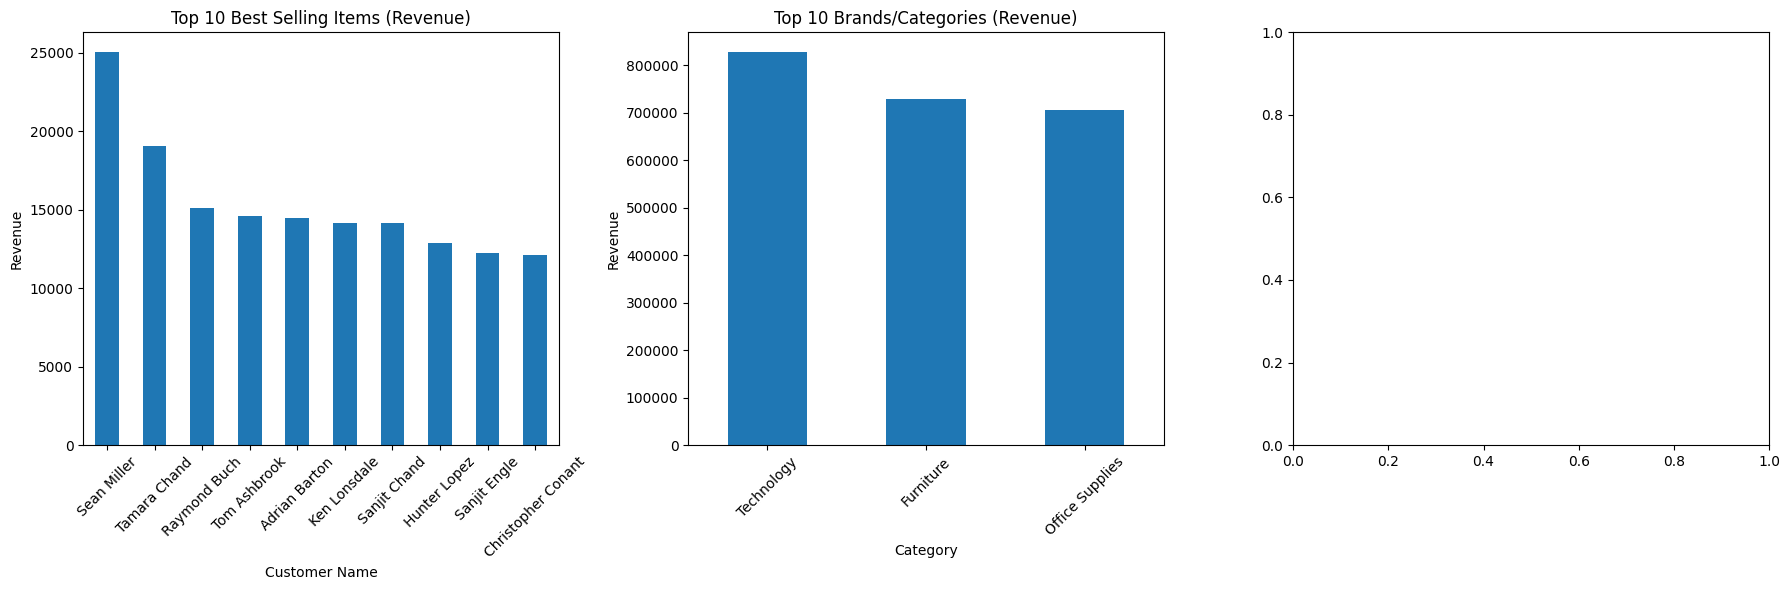

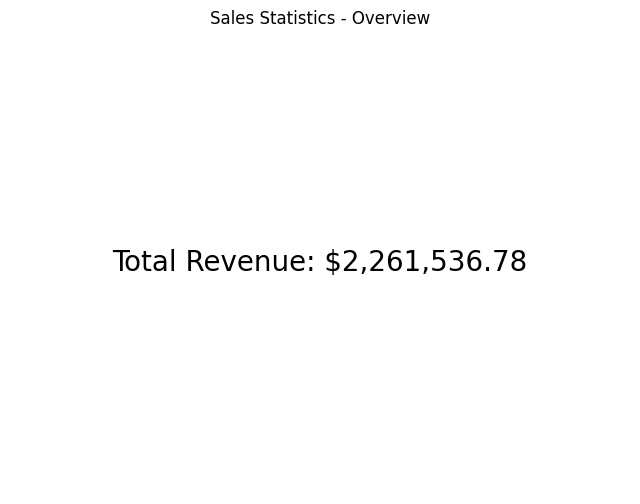

In [ ]:
if __name__ == "__main__":
    main(CONFIG)